In [47]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 

import tensorflow as tf

from tensorflow.keras import Model, Sequential

from tensorflow.keras.layers import Dense, Input

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell, Dropout

from sklearn.preprocessing import MinMaxScaler
#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark") 


tf.random.set_seed(42) # For the reproducibility of the model outcomes
np.random.seed(42)

----
## Project: Forecasting Electricity Consumption of a Household 
----

For this project, we’ll use a dataset that tracks the electric power consumption of a household. The “Individual household electric power consumption” dataset is openly available from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption).

Forecasting electric energy consumption is a common task with worldwide applications. In developing countries, it can help in planning the construction of power grids. In countries where the grid is already developed, forecasting energy consumption ensures that the grid can provide enough energy to power all households efficiently. With accurate forecasting models, energy companies can better plan the load on the grid, ensuring that they are producing enough energy during peak times or have sufficient energy reserves to meet the demand. Also, they can avoid producing too much electricity, which, if it’s not stored, could cause an imbalance in the grid, posing a risk of disconnection. Thus, forecasting electric energy consumption is an important problem that has consequences in our daily lives.

To develop our forecasting model, we’ll use the power consumption dataset men- tioned previously, which contains the electric consumption for a house in Sceaux, France, between December 2006 and November 2010. The data spans 47 months and was recorded at every minute, meaning that we have more than two million data points.

Looking at the data `household_PowConsump.txt`, columns are seperated with `;` which is something we need to deal with when we load the data. 

In [2]:
df = pd.read_csv('household_PowConsump.txt', sep = ';')

df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
df.tail()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0
2075258,26/11/2010,21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


The dataset contains a total of nine columns: 

- `Date`: with a format, dd/mm/yyyy
- `Time`: with format, hh:mm:ss
- `Global_active_power`: The global active power in kilowatts
- `Global_reactive_power`:  The global reactive power in kilowatts Voltage in volts
- `Voltage Global_intensity`: The current intensity in amperes
- `Sub_metering_1`: Energy consumed in the kitchen by a dishwasher, oven, and microwave in watt-hours
- `Sub_metering_2`: Energy consumed in the laundry room by a washing machine, tumble-dryer, refrigerator, and light in watt-hours
- `Sub_metering_3`: Energy consumed by a water heater and air conditioner in watt-hours

The target we are interested in is the `Global_active_power` which measures the total power used by the appliances. `Global_reactive_power`, on the other hand, moves between the source and the load of a circuit, so it does not produce any useful work.


Providing information on weather in addition to this data would be actually quite useful as one would expect for example temperature could be highly relevant for power consumption.  

### 1. Problem Description
-------

To build a model that can forecast the next 24 hours of global active power.

### 2. Data Wrangling, pre-processing and feature engineering
-------

In this section, we will carry all the necessary steps on the data to prepare it for the model building. These include, dealing with missing values, imputing those values, re-sampling the data etc suitable for the project objective, engineering features suitable for the seasonality of the data, scaling the data, and splitting it as train, validation and test sets. 

In [4]:
df.shape # roughly 2 million data points 

(2075259, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


Notice that all columns except the last one has dtype object. We first can combine the first two columns as a string and then render it as a dtype datatime to form a single column to indicate the timestamps in our series. We should also render the remaining object columns into floats.

In [6]:
float_cols = df.columns[2:8]

df[float_cols] = df[float_cols].apply(pd.to_numeric, errors = 'coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


Now we converted the object types to numeric values. We also need to check missing values and deal with them

In [7]:
df.isna().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

For each numerical column the same number of vals are missing. It is likely that they correspond to the same entries. To check this we apply the following code. 

In [8]:
# columns with the same number of missing values
target_columns = df.columns[2:]
# Create a boolean DataFrame for missing values
missing_df = df[target_columns].isna()

# Compare all pairs of columns
matches = {}
for i, col1 in enumerate(target_columns):
    for col2 in target_columns[i + 1:]:
        matches[(col1, col2)] = missing_df[col1].equals(missing_df[col2])

# Print results
for pair, match in matches.items():
    print(f"Columns {pair[0]} and {pair[1]} have matching missing value patterns: {match}")

Columns Global_active_power and Global_reactive_power have matching missing value patterns: True
Columns Global_active_power and Voltage have matching missing value patterns: True
Columns Global_active_power and Global_intensity have matching missing value patterns: True
Columns Global_active_power and Sub_metering_1 have matching missing value patterns: True
Columns Global_active_power and Sub_metering_2 have matching missing value patterns: True
Columns Global_active_power and Sub_metering_3 have matching missing value patterns: True
Columns Global_reactive_power and Voltage have matching missing value patterns: True
Columns Global_reactive_power and Global_intensity have matching missing value patterns: True
Columns Global_reactive_power and Sub_metering_1 have matching missing value patterns: True
Columns Global_reactive_power and Sub_metering_2 have matching missing value patterns: True
Columns Global_reactive_power and Sub_metering_3 have matching missing value patterns: True
Col

Roughly one percent of each numerical column is missing. This could be due to holidays taken by the occupants or a malfunction in the measurement due to for example a failure in the reading system. 

We should decide how we should fill these values. Lets first check if the missing values occur consequtively. To count the length of group of data with NaN, we use the solution suggested [here](https://stackoverflow.com/questions/29007830/identifying-consecutive-nans-with-pandas).

In [9]:
na_groups = df['Sub_metering_3'].notna().cumsum()[df['Sub_metering_3'].isna()]

lengths_consecutive_na = na_groups.groupby(na_groups).agg(len)

longest_na_gap = lengths_consecutive_na.max()

print(f'Longest NA gap in the data is {longest_na_gap}')

Longest NA gap in the data is 7226


There is max of 7,226 consecutive minutes of missing data, which is equivalent to roughly 5 days. The gap is actually too large. We could deal with this issue by resampling the data less granually than the largest gap, e.g one option would be weekly resampling but this would change our task. Instead we will fill them.  

In [10]:
# number of instances where daily consequtive data is missing 

(lengths_consecutive_na < 24 * 60).sum()

65

At this point we need to decide how to fill the missing values. They all correspond to the same datetime stamps for all columns. If we drop these entries we will have gaps in the time series. For this purpose lets check the distribution of the data. 

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528,11.122
Global_reactive_power,2049280.0,0.123714,0.112722,0.000,0.048,0.100,0.194,1.390
Voltage,2049280.0,240.839858,3.239987,223.200,238.990,241.010,242.890,254.150
Global_intensity,2049280.0,4.627759,4.444396,0.200,1.400,2.600,6.400,48.400
Sub_metering_1,2049280.0,1.121923,6.153031,0.000,0.000,0.000,0.000,88.000
Sub_metering_2,2049280.0,1.298520,5.822026,0.000,0.000,0.000,1.000,80.000
Sub_metering_3,2049280.0,6.458447,8.437154,0.000,0.000,1.000,17.000,31.000


We see that mean and the medians are not too far away from each other for all columns. However the data range is pretty wide for all columns except maybe `Voltage`. For all other columns mean and median is quite away from the min and max values this implies that there are some outliers in these columns. To keep the data quality we can therefore fill the missing values with the mean of each column.  

In [12]:
df[target_columns] = df[target_columns].fillna(df[target_columns].mean())

In [13]:
df.isna().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Next, lets plot our target to see if it the minute by minute data is suitable for modelling, if it is too noisy it will be hard to model it given its current form.  

Text(0.5, 1.0, 'Data for the first day')

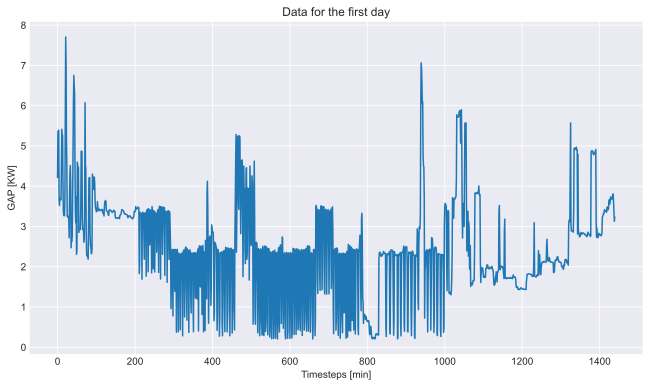

In [14]:
min_to_plot = 24 * 60

fig, axes = plt.subplots(figsize = (11,6))

axes.plot(df['Global_active_power'][:min_to_plot])

axes.grid()
axes.set_ylabel('GAP [KW]')
axes.set_xlabel('Timesteps [min]')
axes.set_title('Data for the first day')

We see that minute by minute data is very noisy. It is hard to model such a data, so we will instead sample it hourly. For this purpose, we will first combine the `Date` and `Time` columns and render the resulting column as datetime and finally drop the reduntant ones. 

In [15]:
df.loc[:,'Datetime']  = pd.to_datetime(df.Date.astype(str)+ " " + df.Time.astype(str))

In [16]:
# Drop the redundant columns 

df = df.drop(['Date', 'Time'], axis = 1)

df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


In [17]:
# set index 

df.set_index('Datetime', inplace = True)

df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [18]:
df.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0
2010-11-26 21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [19]:
# Finally resample by taking hourly sum of each column

hourly_df = df.resample('h').sum()

hourly_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0


In [20]:
hourly_df.tail(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2010-12-11 14:00:00,79.256,8.980,14270.39,341.4,0.0,0.0,405.0
2010-12-11 15:00:00,107.446,11.282,14167.13,476.8,0.0,31.0,870.0
2010-12-11 16:00:00,81.700,15.632,14138.44,353.8,0.0,69.0,114.0
2010-12-11 17:00:00,147.366,7.356,13856.42,637.4,0.0,4.0,601.0
2010-12-11 18:00:00,136.852,5.866,13834.26,591.6,0.0,0.0,0.0
2010-12-11 19:00:00,143.518,6.828,13931.03,620.2,21.0,0.0,788.0
2010-12-11 20:00:00,105.200,5.090,14040.45,450.0,483.0,66.0,604.0
2010-12-11 21:00:00,66.894,5.148,14192.62,284.8,513.0,27.0,0.0
2010-12-11 22:00:00,19.232,4.574,14408.44,82.4,0.0,0.0,0.0


Notice that after re-sampling we have more data at the tail of the dataframe. We first filter the reduce the date range the same as the original dataframe. The original data frame has entries from 16th December 2006 17:24:00 until 26th November 2010 21:02:00 and since we are sampling hourly we first filter the hourly_df between 16th December 2006 17:00:00 until 26th November 2010 21:00:00

In [21]:
init = '2006-12-16 17:00:00'
fin = '2010-11-26 21:00:00'

df_h = hourly_df[init:fin]

df_h.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2010-11-26 17:00:00,103.554,3.684,14224.18,433.0,0.0,0.0,772.0
2010-11-26 18:00:00,94.408,3.222,14251.91,397.2,0.0,0.0,0.0
2010-11-26 19:00:00,99.560,3.602,14204.46,423.4,0.0,4.0,0.0
2010-11-26 20:00:00,69.822,3.670,14363.76,294.8,0.0,64.0,0.0
2010-11-26 21:00:00,2.804,0.000,719.07,11.4,0.0,0.0,0.0


Now recall from the head and tail of the original data that first entries start from time stamp of 17:24, so the first hour is in the resampled data aggrated using 35 min of data. While the last is only for 2 minutes from 21:00:00 to 21:02:00, we should therefore get rid of the first and last entries in the `df_h` for proper sampling purposes. 

In [22]:
df_h = df_h.drop(df_h.head(1).index)
df_h = df_h.drop(df_h.tail(1).index)

df_h.head(1)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0


Text(0.5, 1.0, 'Hourly Sampled Data')

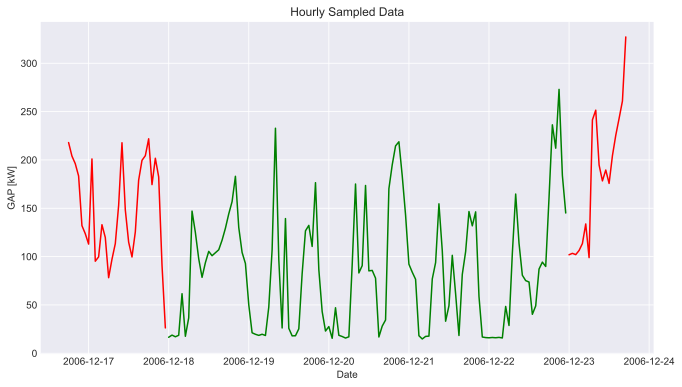

In [23]:
# Plot to visualize the re-sampled data 

hour_to_plot = 7 * 24

weekend_mask = df_h[:hour_to_plot].index.dayofweek >= 5
weekday_mask = df_h[:hour_to_plot].index.dayofweek < 5

df_we = df_h[:hour_to_plot][weekend_mask]
df_wd = df_h[:hour_to_plot][weekday_mask]

# Group by week number
df_we['week'] = df_we.index.to_series().dt.isocalendar().week
df_wd['week'] = df_wd.index.to_series().dt.isocalendar().week

fig, axes = plt.subplots(figsize = (11,6))

for week, group in df_we.groupby('week'):
    axes.plot(group.index, group['Global_active_power'], label=f'Weekend {week}', color = 'red')

for week, group in df_wd.groupby('week'):
    axes.plot(group.index, group['Global_active_power'], label=f'Weekdays {week}', color = 'green')

axes.grid()
axes.set_xlabel('Date')
axes.set_ylabel('GAP [kW]')
axes.set_title('Hourly Sampled Data')

We have a more discernable pattern in the hourly data which is more suitable for modelling. Weekends tend to have more energy consumption but this is not a particularly re-occuring pattern. Some weekends (red) even have smaller energy consumption than weekdays (green). With hourly sampling, daily seasonality is probabibly easier to capture where we have roughly two peaks per day. 

In [24]:
# save the cleaned data for later use 

df_h.to_csv('PowerConsump_clean.csv', header = True, index = True)

#### Feature Engineering
------

In [25]:
df_h  = pd.read_csv('PowerConsump_clean.csv', index_col= 0, parse_dates = True)

df_h.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0
2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0,266.0


In [26]:
# statistics summary of re-sampled columns 

df_h.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34587.0,64.986674,53.677967,0.0,20.422,48.54,93.828,393.632
Global_reactive_power,34587.0,7.363554,4.023023,0.0,4.660,6.43,8.889,46.460
Voltage,34587.0,14339.842553,1270.237349,0.0,14349.085,14454.70,14559.505,15114.120
Global_intensity,34587.0,275.512087,224.757739,0.0,90.400,207.00,392.200,1703.000
Sub_metering_1,34587.0,66.877573,210.601595,0.0,0.000,0.00,0.000,2902.000
Sub_metering_2,34587.0,77.387795,249.453543,0.0,0.000,20.00,40.000,2786.000
Sub_metering_3,34587.0,383.844126,437.713524,0.0,39.000,100.00,825.000,1293.000


Notice that 75 percent of `Sub_metering_1` has 0 values therefore it will not serve as a good predictor. We will simply drop it

In [27]:
df_h = df_h.drop('Sub_metering_1', axis = 1)

df_h.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2,Sub_metering_3
Datetime,,,,,,
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,25.0,1033.0
2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,8.0,266.0


By inspecting the plots of our target we have inferred that there could be daily seasonality in the data which indeed makes sense. To solidfy this statement we can make a Fourier x-form of our target and search for different seasonality.

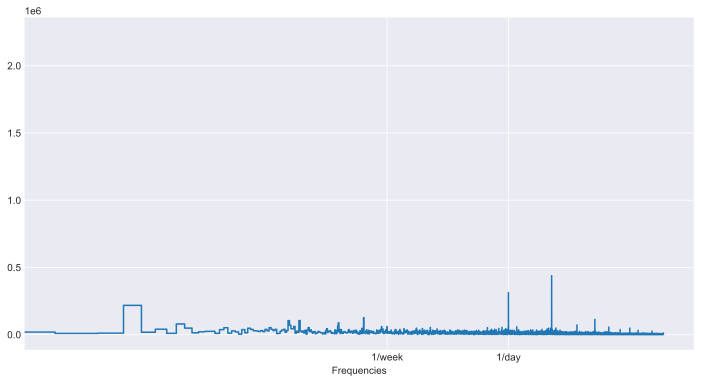

In [28]:
ft = tf.signal.rfft(df_h['Global_active_power']) # returns fouriers x-formed series 

freq_per_data = np.arange(0, len(ft)) # length of the fourier x-form sets the number of frequencies 

n_sample = len(df_h['Global_active_power']) # total samples in hours

h_per_w = 24 * 7

w_per_data = n_sample / h_per_w # total number of weeks in the hourly data

freq_per_w = freq_per_data / w_per_data # frequency of a week 

fig, axes = plt.subplots(figsize = (12,6))

axes.step(freq_per_w, np.abs(ft))
axes.set_xscale('log')
axes.set_xlabel('Frequencies')
axes.set_xticks([1,7], ['1/week', '1/day'])
axes.grid()



Peak in the daily frequency confirms our expectations on daily seasonality of the data. We can engineer features that can allow us to capture daily seasonality, by generating indicators of a time during the day. 

In [29]:
timestamp_s = df_h.index.map(datetime.timestamp) # timestamps in the df in seconds

timestamp_s[5]-timestamp_s[4] == 3600 # each consequtive time stamp has 3600 second difference

True

In [30]:
day_sec = 24 * 60 * 60 #total seconds in a day

df_h['day_sin'] = (np.sin(timestamp_s * (2*np.pi)/day_sec)).values

df_h['day_cos'] = (np.cos(timestamp_s * (2*np.pi)/day_sec)).values 

# sin transformation alone is not sufficient because it does not distinguish between pi/2 (say 6 am) and 3pi/2 (say 6pm) 
# we therefore engineer another feature using cos x-form as it is known to be out of phase with sin
# In essence we use sin and cos features as basis vectors for any cyclical pattern that can be present in time  

In [31]:
df_h.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2,Sub_metering_3,day_sin,day_cos
Datetime,,,,,,,,
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,403.0,1012.0,-0.965926,-2.588190e-01
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,86.0,1001.0,-1.000000,-4.501728e-12
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,1007.0,-0.965926,2.588190e-01
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,25.0,1033.0,-0.866025,5.000000e-01
2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,8.0,266.0,-0.707107,7.071068e-01


<Axes: xlabel='Datetime'>

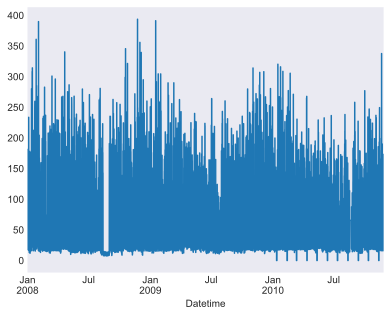

In [32]:
df_h['2008':'2010']['Global_active_power'].plot()

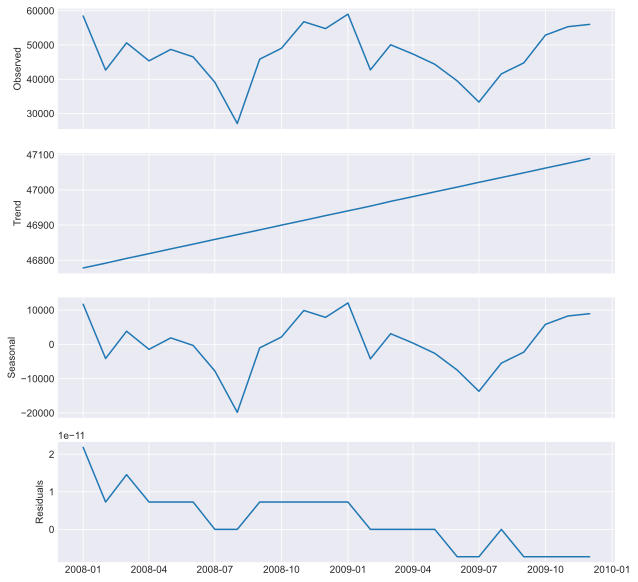

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

df_m = df_h['2008':'2009'].resample('MS').sum()

decomp = STL(df_m['Global_active_power'], period = 12).fit()

fig, axes = plt.subplots(4,1, figsize = (10,10), sharex=True)

axes[0].plot(decomp.observed)
axes[0].set_ylabel('Observed')

axes[1].plot(decomp.trend)
axes[1].set_ylabel('Trend')

axes[2].plot(decomp.seasonal)
axes[2].set_ylabel('Seasonal')

axes[3].plot(decomp.resid)
axes[3].set_ylabel('Residuals')

for i in range(4):

    axes[i].grid()

Towards summer months we have a decrease in the consumption and increase towards winter. We could add an indicator to help the model to catch this pattern. As we have done for the daily seasonality, we will do this automatically using the statsmodels library with `DeterministicProcess()` method. 
This may help to capture yearly seasonality. See e.g [here](https://towardsdatascience.com/modeling-variable-seasonal-features-with-the-fourier-transform-18c792102047). 

In [35]:
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

cfr = CalendarFourier(freq='Y', order=1)
seasonal_year_trig = DeterministicProcess(index=df_h.index, seasonal=False, additional_terms=[cfr]).in_sample() # seasonal = False to avoid dummies
with pd.option_context('display.max_columns', None, 'display.expand_frame_repr', False):
    print(seasonal_year_trig)



                     sin(1,freq=A-DEC)  cos(1,freq=A-DEC)
Datetime                                                 
2006-12-16 18:00:00          -0.259512           0.965740
2006-12-16 19:00:00          -0.258819           0.965926
2006-12-16 20:00:00          -0.258126           0.966111
2006-12-16 21:00:00          -0.257433           0.966296
2006-12-16 22:00:00          -0.256740           0.966481
...                                ...                ...
2010-11-26 16:00:00          -0.571420           0.820658
2010-11-26 17:00:00          -0.570831           0.821067
2010-11-26 18:00:00          -0.570242           0.821477
2010-11-26 19:00:00          -0.569653           0.821885
2010-11-26 20:00:00          -0.569063           0.822294

[34587 rows x 2 columns]


In [36]:
seasonal_year_trig.columns = ['y_sin1', 'y_cos1']

seasonal_year_trig.head()

,y_sin1,y_cos1
Datetime,,
2006-12-16 18:00:00,-0.259512,0.965740
2006-12-16 19:00:00,-0.258819,0.965926
2006-12-16 20:00:00,-0.258126,0.966111
2006-12-16 21:00:00,-0.257433,0.966296
2006-12-16 22:00:00,-0.256740,0.966481


In [37]:
# add the features to our re-sampled data frame 

df_hf = pd.concat([df_h, seasonal_year_trig], axis =1)


In [38]:
df_hf.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_2,Sub_metering_3,day_sin,day_cos,y_sin1,y_cos1
Datetime,,,,,,,,,,
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,403.0,1012.0,-0.965926,-2.588190e-01,-0.259512,0.965740
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,86.0,1001.0,-1.000000,-4.501728e-12,-0.258819,0.965926
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,1007.0,-0.965926,2.588190e-01,-0.258126,0.966111
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,25.0,1033.0,-0.866025,5.000000e-01,-0.257433,0.966296
2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,8.0,266.0,-0.707107,7.071068e-01,-0.256740,0.966481


#### Split the data and Scale
-------
train, val, test : 70/20/10

In [39]:
n_sample = len(df_hf)

train_df, val_df, test_df = df_hf[:int(n_sample * 0.7)].copy(), df_hf[int(n_sample * 0.7):int(n_sample * 0.9)].copy(), df_hf[int(n_sample * 0.9):].copy()

# Scale

scaler = MinMaxScaler()

scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])


In [41]:
# save them for later use

train_df.to_csv('train_pp.csv', index = True, header = True)
val_df.to_csv('val_pp.csv', index = True, header = True)
test_df.to_csv('test_pp.csv', index = True, header = True)

### Model Building and Selection
------

Since our task is to predict next 24 hours of `Global_active_power` consumption, we must build a univariate multi-step model. 

For this purpose, we will generate two-baselines and build a deep neural network model, a long short-term memory (LSTM) model, a convolutional neural network (CNN), a combination of CNN and LSTM, and finally an autoregressive LSTM. In the end, we will use mean absolute error (MAE) on the test set to determine which model is the best.

In [42]:
# First load the data we just saved 

train = pd.read_csv('train_pp.csv', index_col = 0)
val = pd.read_csv('val_pp.csv', index_col = 0)
test = pd.read_csv('test_pp.csv', index_col = 0)



In [43]:
# GAP is the new target

ncol_names = ['GAP', 'GRP', 'Volt', 'GI', 'SM2', 'SM3', 'd_sin', 'd_cos', 'y_sin1', 'y_cos1']

train.columns = ncol_names
val.columns = ncol_names
test.columns = ncol_names

train['ds'] = train_df.index
val['ds'] = val_df.index
test['ds'] = test_df.index

In [44]:
# set index

train.set_index('ds', inplace = True)
val.set_index('ds', inplace = True)
test.set_index('ds', inplace = True)

In [45]:
# store column indices and names in a dictionary

column_indices = {name: i for i, name in enumerate(train.columns)}

column_indices

{'GAP': 0,
 'GRP': 1,
 'Volt': 2,
 'GI': 3,
 'SM2': 4,
 'SM3': 5,
 'd_sin': 6,
 'd_cos': 7,
 'y_sin1': 8,
 'y_cos1': 9}

In [49]:
# DataWindow class to generate data suitable for training and plotting after the training

class DataWindow():

    def __init__(self, input_width, label_width, shift, train_df = train, val_df = val, test_df = test, label_columns = None):
        
        '''Initialization function that assigns variables and manages indices of inputs and labels'''
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns # Name(s) of the target column(s)
        
        # Assigning dictionaries to label and feature names (as keys) with specified indices as values 
        if label_columns is not None:
        
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)} # a dictionary with the name of label column as key
                                                                                           # and index i as the value

        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} # a dictionary with feature column names as keys # and an index i as values.
                                                                                   # It will be used to split featurus from the target(s)
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.tot_dwindow_size = input_width + shift # total data window size

        # assigning input and label indices within a data window 

        self.input_slice = slice(0, input_width) # slice function determines how to split a sequence                                      
        self.input_indices = np.arange(self.tot_dwindow_size)[self.input_slice]

        self.label_s_idx = self.tot_dwindow_size - self.label_width # label start index 
        self.label_slice = slice(self.label_s_idx, None) # slice from the start till the end 
        self.label_indices = np.arange(self.tot_dwindow_size)[self.label_slice]

    def split_inputs_labels(self, features): # method to split the data window into inputs and label 

        inputs = features[:, self.input_slice, :] 
        labels = features[:, self.label_slice, :]

        if self.label_columns is not None: # if we have more than one label we stack the labels 

            labels = tf.stack([labels[:,:,self.column_indices[name]] for name in self.label_columns], axis = -1)

            inputs.set_shape([None, self.input_width, None]) # the full shape will be [# of batches, time, features]
            labels.set_shape([None, self.label_width, None]) # At this point, we only specify the time dimension and allow the batch and feature dimensions to be defined later.

        return inputs, labels 

    def plot(self, model = None, plot_col = 'GAP', max_subplots = 3):
        
        ''' function to plot the input data, the predictions, and the actual values. Since we will be working with many time windows, 
            we will show only the plot of three time windows, but this parameter can easily be changed.  '''

        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
       
        
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)
            
            if self.label_columns:
                
                label_col_index = self.label_columns_indices.get(plot_col, None)

            else:
                
                label_col_index = plot_col_index

            if label_col_index is None:
                
                continue

            # plot true values, as green squares.        
            plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', marker='s', label='Labels', c='green', s=64)

            if model is not None:

                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index], edgecolors='k', marker='X', label='Predictions', c='red', s=64)

            if n == 0:

                plt.legend()

            plt.grid()


        plt.xlabel('Time [h]')
        


    def make_dataset(self, data): # data will be our train, val and test

        data = np.array(data, dtype=np.float32)

        ds = tf.keras.preprocessing.timeseries_dataset_from_array(data = data, targets = None, sequence_length = self.tot_dwindow_size, sequence_stride = 1, shuffle = True, batch_size = 32)

        # targets are set to None because the split_inputs_labels function will take care of it

        ds = ds.map(self.split_inputs_labels)

        return ds

    # defining some properties to apply the make_dataset function on the training, validation, and testing sets.
    # We also create a sample batch that we’ll cache within the class for plotting purposes.    

    @property
    def train(self):
         
        return self.make_dataset(self.train_df)

    @property
    def val(self):
            
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):

        result = getattr(self, '_sample_batch', None)
    
        if result is None:
    
            result = next(iter(self.train))
            self._sample_batch = result
    
        return result                                                                               
         
                                                                                    

In [48]:
# Function to compile and fit DL models

def compile_and_fit(model, window, patience = 3, max_epochs = 50): # takes a model and a window of data from the DataWindow class 
                                                                   # The patience is the number of epochs after which the model should stop training if the validation loss
                                                                   # does not improve; max_epochs sets a maximum number of epochs to train the model.
        early_stopping = EarlyStopping(monitor = 'val_loss', patience = patience, mode = 'min')

        model.compile(loss = MeanSquaredError(), optimizer = 'adam', metrics = [MeanAbsoluteError()])

        history = model.fit(window.train, epochs = max_epochs, validation_data = window.val, callbacks = [early_stopping])

        return history

#### Establishing Baselines
------
Before moving on to building deep learning models we need to establish a baseline performance that more complicated models expect to improve. Recall that we are interested in predicting next 24 hour consumption. 

In this situation, there are two reasonable baselines:

- Predict the last known value for the next 24 timesteps.
- Predict the last 24 timesteps for the next 24 timesteps.

With that in mind, let’s implement the first baseline, where we’ll simply repeat the last
known value over the next 24 timesteps.

In [50]:
# class for a naive multi-step forecast model, inherited from the Model class of keras

class MS_Naive(Model):
    
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        
        if self.label_index is None:
                 
            return tf.tile(inputs[:,-1:,:], [1,24,1]) # If no target is specified, return the last known value of all columns over the next 24 timesteps.

        return tf.tile(inputs[:,-1:,self.label_index:], [1,24,1]) # else return the last known value of the target column over the next 24 timesteps.


In [51]:
# class for a naive multi-step forecast model where previous n inputs are used to predict the next n vals 

class MS_NaiveRepeat(Model):
    
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        
        if self.label_index is None:
                 
            return inputs[:,:,:] # If no target is specified, return the last n inputs as predictions for the next n timesteps.

        return inputs[:,:,self.label_index:] # else return the same for the specified target index

To put the performance of the baselines in effect. First generate multi-step window where we use last 24 steps to predict next 24. 

In [52]:
multi_window = DataWindow(input_width = 24, label_width = 24, shift = 24, label_columns = ['GAP'])

In [53]:
# The baseline classes we set inherits from keras Model, therefore we can pretend like they act like a normal DL model, the only exception is 
# the training process which is not present for the baselines, i.e no epochs and no optimizer 

naive_model = MS_Naive(label_index = column_indices['GAP'])
naive_repeat_model = MS_NaiveRepeat(label_index = column_indices['GAP'])

val_performance = {} # empty dictionaries to store validation and test performance of all models we will study
performance = {}

naive_model.compile(loss = 'mse', metrics = [MeanAbsoluteError()])
naive_repeat_model.compile(loss = 'mse', metrics = [MeanAbsoluteError()])


val_performance['Naive'] = naive_model.evaluate(multi_window.val, verbose = 0)
performance['Naive'] = naive_model.evaluate(multi_window.test, verbose = 0)


val_performance['Naive_repeat'] = naive_repeat_model.evaluate(multi_window.val, verbose = 0)
performance['Naive_repeat'] = naive_repeat_model.evaluate(multi_window.test, verbose = 0)



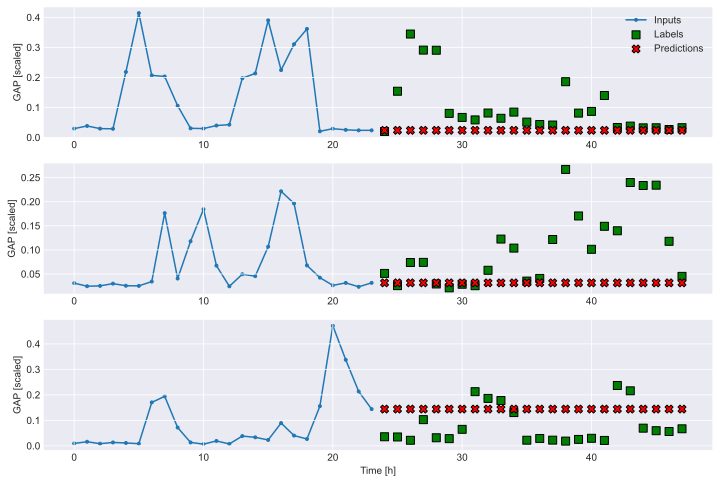

In [54]:
# plot to visualise/ assess the predictive power of baselines

multi_window.plot(naive_model)

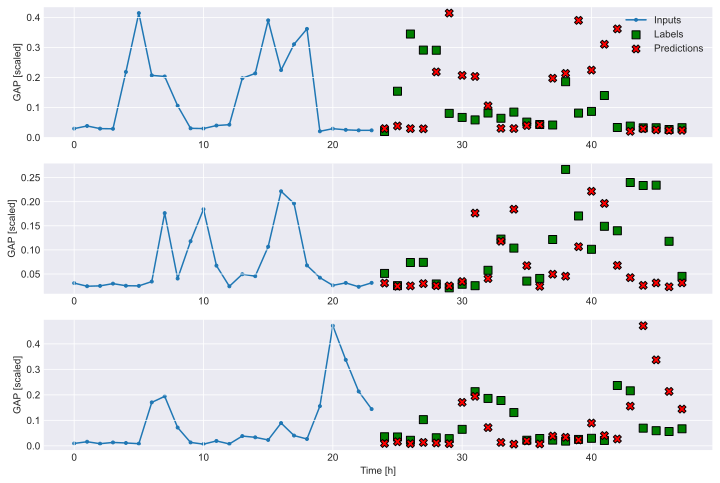

In [55]:
multi_window.plot(naive_repeat_model)

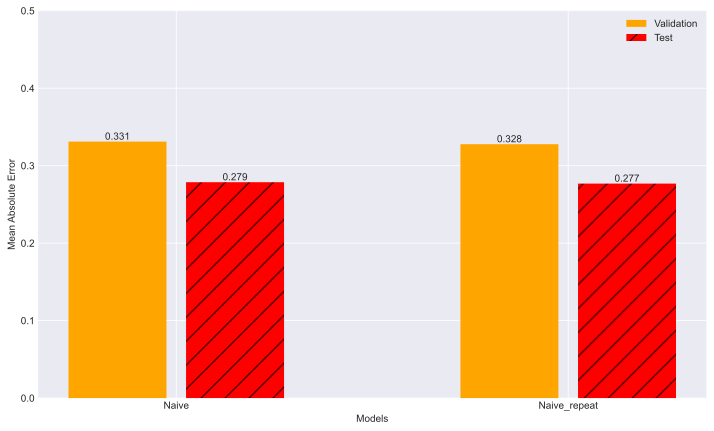

In [56]:
# Compare the baselines 

mae_val = [val[1] for val in val_performance.values()]
mae_test = [val[1] for val in performance.values()]

x = np.arange(len(performance))

fig, axes = plt.subplots(figsize = (12,7))

axes.bar(x - 0.15, mae_val, width = 0.25, color = 'orange', label = 'Validation')
axes.bar(x + 0.15, mae_test, width = 0.25, color = 'red', hatch = '/', label = 'Test')

for idx, val in enumerate(mae_val):

    axes.text(s = str(round(val,3)), x = idx - 0.15, y = val + 0.0025, ha = 'center')

for idx, val in enumerate(mae_test):

    axes.text(s = str(round(val,3)), x = idx + 0.15, y = val + 0.0025, ha = 'center')

axes.grid()
axes.set_ylabel('Mean Absolute Error')
axes.set_xlabel('Models')
axes.set_xticks(ticks = x, labels = performance.keys())
axes.set_ylim(0,0.5)
axes.legend()

Naive repeat baseline performs slighltly better. We can take it as the baseline in what follows. We can move on the build more complex models

In [60]:
# Deep Neural Network 

dnn_model = Sequential([Dense(32, activation = 'relu'),Dropout(0.5),Dense(32, activation = 'relu'),Dropout(0.5),Dense(1, kernel_initializer = tf.initializers.zeros)])

history = compile_and_fit(dnn_model, multi_window)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0206 - mean_absolute_error: 0.1089 - val_loss: 0.0185 - val_mean_absolute_error: 0.0988
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0165 - mean_absolute_error: 0.0989 - val_loss: 0.0159 - val_mean_absolute_error: 0.0950
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0162 - mean_absolute_error: 0.0973 - val_loss: 0.0149 - val_mean_absolute_error: 0.0933
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0160 - mean_absolute_error: 0.0966 - val_loss: 0.0147 - val_mean_absolute_error: 0.0924
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0159 - mean_absolute_error: 0.0962 - val_loss: 0.0148 - val_mean_absolute_error: 0.0923
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0158 - mean_absolute_error: 0.0957 - val_loss: 0.0149 - val_mean_absolute_error: 0.0925
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0158 - mean_absolute_error: 0.0957 - v

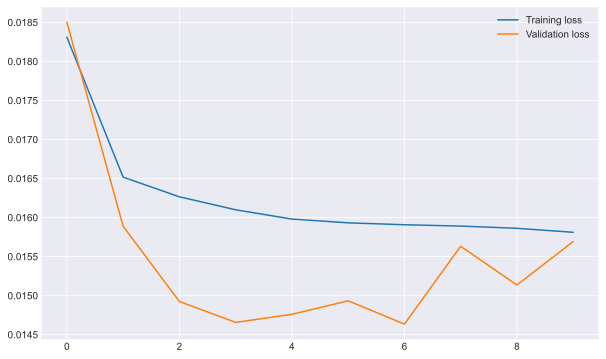

In [62]:
fig, axes = plt.subplots(figsize = (10,6))

axes.plot(history.history['loss'], label = 'Training loss')
axes.plot(history.history['val_loss'], label = 'Validation loss')

axes.grid()
axes.legend()

In [63]:
dnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 24, 32)         │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24, 32)         │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,325 (16.90 KB)

 Trainable params: 1,441 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,884 (11.27 KB)

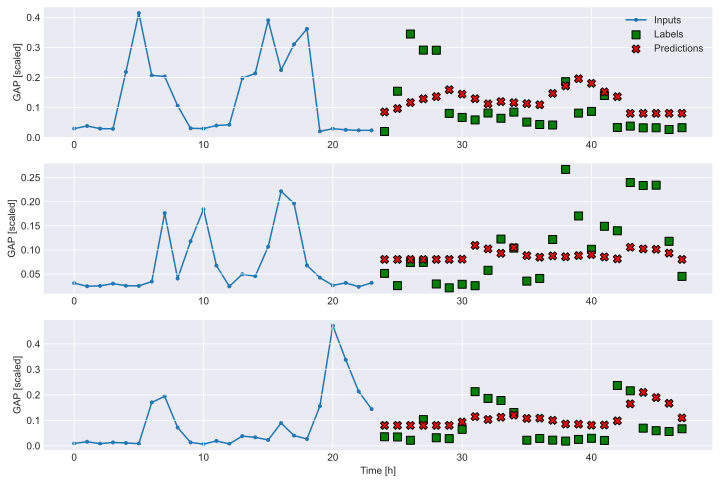

In [64]:
# Visualize 

multi_window.plot(dnn_model)

In [65]:
# Save performance 

val_performance['DNN'] = dnn_model.evaluate(multi_window.val, verbose = 0)
performance['DNN'] = dnn_model.evaluate(multi_window.test, verbose = 0)


In [66]:
# LSTM

lstm_model = Sequential([LSTM(32,return_sequences = True), Dropout(0.5), Dense(1, kernel_initializer = tf.initializers.zeros)])

history = compile_and_fit(lstm_model, multi_window)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0199 - mean_absolute_error: 0.1067 - val_loss: 0.0138 - val_mean_absolute_error: 0.0893
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0156 - mean_absolute_error: 0.0944 - val_loss: 0.0127 - val_mean_absolute_error: 0.0855
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0151 - mean_absolute_error: 0.0925 - val_loss: 0.0125 - val_mean_absolute_error: 0.0847
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0149 - mean_absolute_error: 0.0913 - val_loss: 0.0129 - val_mean_absolute_error: 0.0872
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0148 - mean_absolute_error: 0.0909 - val_loss: 0.0130 - val_mean_absolute_error: 0.0862
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0147 - mean_absolute_error: 0.0904 - val_loss: 0.0139 - val_mean_absolute_error: 0.0886


In [67]:
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 32)         │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 24, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,613 (64.90 KB)

 Trainable params: 5,537 (21.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,076 (43.27 KB)

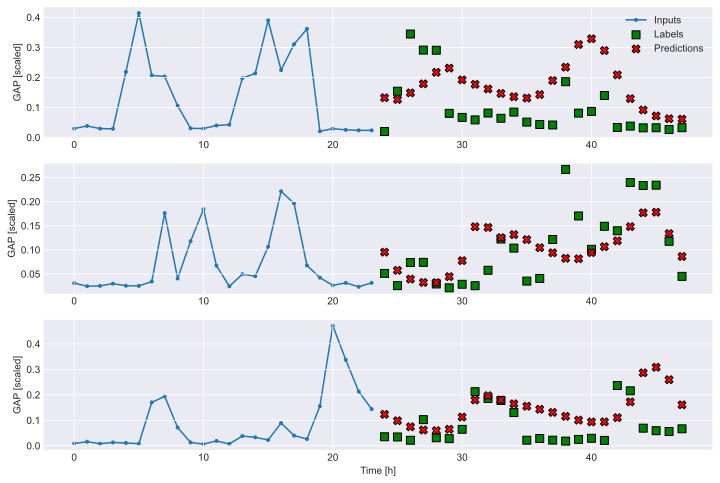

In [68]:
# LSTM has almost 5 folds more model parameters 

multi_window.plot(lstm_model)

In [69]:
# Save performance 

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val, verbose = 0)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose = 0)

In [70]:
# CNN Model, Recall that since we use a filter/kernel over the time series, input width should be larger so that we can generate 24 outputs 

KERNEL_WIDTH = 3
LABEL_WIDTH = 24

INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindow(input_width = INPUT_WIDTH, label_width = LABEL_WIDTH, shift = 24, label_columns = ['GAP'])

In [71]:
cnn_model = Sequential([Conv1D(26, kernel_size = (KERNEL_WIDTH,), activation = 'relu'), Dense(units = 26, activation = 'relu'), Dropout(0.5), Dense(1, kernel_initializer = tf.initializers.zeros)])

history = compile_and_fit(cnn_model, conv_window)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0193 - mean_absolute_error: 0.1031 - val_loss: 0.0141 - val_mean_absolute_error: 0.0889
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0153 - mean_absolute_error: 0.0929 - val_loss: 0.0133 - val_mean_absolute_error: 0.0865
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0151 - mean_absolute_error: 0.0920 - val_loss: 0.0132 - val_mean_absolute_error: 0.0863
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0149 - mean_absolute_error: 0.0913 - val_loss: 0.0134 - val_mean_absolute_error: 0.0865
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0149 - mean_absolute_error: 0.0912 - val_loss: 0.0131 - val_mean_absolute_error: 0.0852
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0148 - mean_absolute_error: 0.0910 - val_loss: 0.0134 - val_mean_absolute_error: 0.0864
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0148 - mean_absolute_error: 0.0910 - v

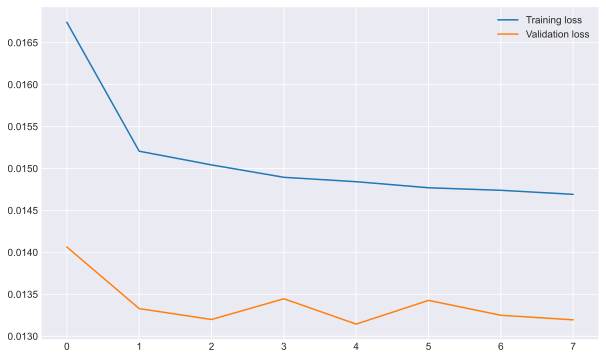

In [72]:
fig, axes = plt.subplots(figsize = (10,6))

axes.plot(history.history['loss'], label = 'Training loss')
axes.plot(history.history['val_loss'], label = 'Validation loss')

axes.grid()
axes.legend()

We could have stopped earlier as it seems like the model starts to overfit. 

In [73]:
cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 26)         │           806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 24, 26)         │           702 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 26)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 24, 1)          │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,607 (18.00 KB)

 Trainable params: 1,535 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,072 (12.00 KB)

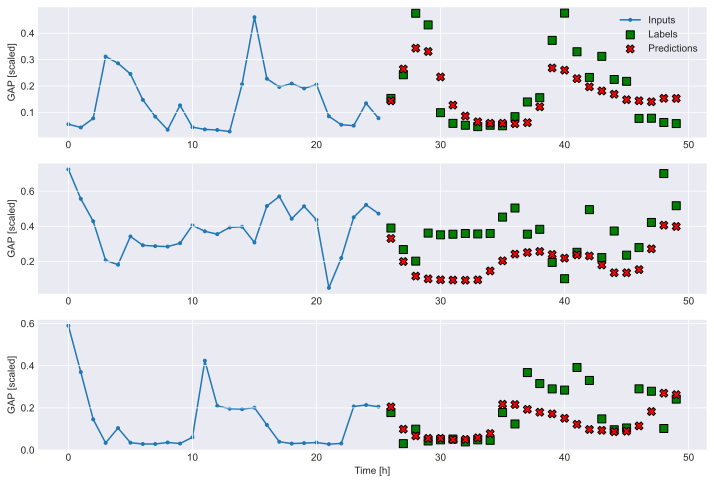

In [74]:
# CNN model we built was rather simpler as compared to the LSTM

conv_window.plot(cnn_model)

In [75]:
# Save performance 

val_performance['CNN'] = cnn_model.evaluate(conv_window.val, verbose = 0)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose = 0)

In [79]:
# CNN + LSTM 

cnn_lstm_model = Sequential([Conv1D(26, kernel_size = (KERNEL_WIDTH,), activation = 'relu'), Dropout(0.5), LSTM(26, return_sequences = True), Dropout(0.5), Dense(1, kernel_initializer = tf.initializers.zeros)])

history = compile_and_fit(cnn_lstm_model, conv_window)



Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0204 - mean_absolute_error: 0.1083 - val_loss: 0.0131 - val_mean_absolute_error: 0.0869
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0157 - mean_absolute_error: 0.0947 - val_loss: 0.0127 - val_mean_absolute_error: 0.0855
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0153 - mean_absolute_error: 0.0932 - val_loss: 0.0125 - val_mean_absolute_error: 0.0848
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0151 - mean_absolute_error: 0.0921 - val_loss: 0.0124 - val_mean_absolute_error: 0.0846
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0150 - mean_absolute_error: 0.0917 - val_loss: 0.0125 - val_mean_absolute_error: 0.0837
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0149 - mean_absolute_error: 0.0913 - val_loss: 0.0126 - val_mean_absolute_error: 0.0846
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0148 - mean_absolute_error: 0.0909 - v

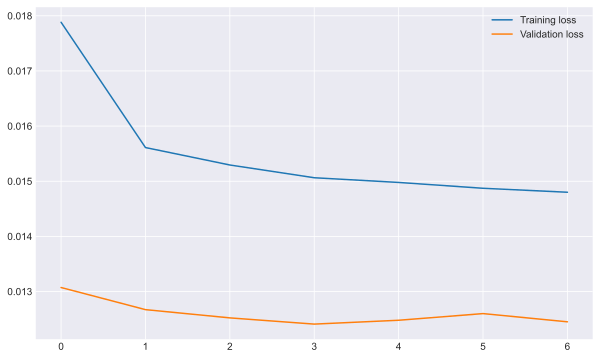

In [80]:
fig, axes = plt.subplots(figsize = (10,6))

axes.plot(history.history['loss'], label = 'Training loss')
axes.plot(history.history['val_loss'], label = 'Validation loss')

axes.grid()
axes.legend()

In [81]:
cnn_lstm_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 24, 26)         │           806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 26)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 26)         │         5,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24, 26)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 24, 1)          │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,037 (74.37 KB)

 Trainable params: 6,345 (24.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,692 (49.58 KB)

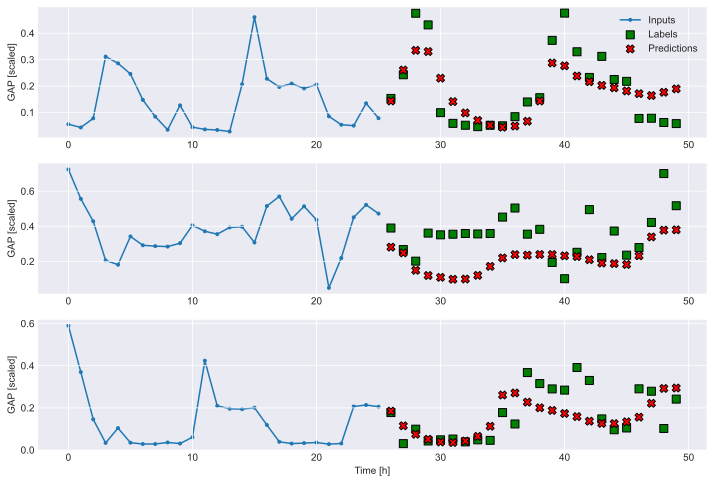

In [82]:
# plot predictions 

conv_window.plot(cnn_lstm_model)

In [83]:
# Save performance 

val_performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.val, verbose = 0)
performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose = 0)

In [87]:
# AR LSTM 
# The final model that we’ll implement is an autoregressive LSTM (ARLSTM) model. Instead of generating the entire output sequence in a single shot, 
# the autoregressive model will generate one prediction at a time and use that prediction as an input to generate the next one.

class AutoRegressive(Model):

    def __init__(self, units, out_steps):
        super().__init__()
        
        self.out_steps = out_steps
        self.units = units

        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state = True)
        self.dropout = Dropout(0.5)
        self.dense = Dense(train.shape[1])

    def warmup(self, inputs):

        x, *state = self.lstm_rnn(inputs)

        pred = self.dense(x)

        return pred, state

    def call(self, inputs, training = None):

        preds = []

        pred, state = self.warmup(inputs)

        preds.append(pred)

        for n in range(1, self.out_steps):

            x = pred

            x, state = self.lstm_cell(x, states = state, training = training)

            pred = self.dense(x)
            preds.append(pred)
        
        preds = tf.stack(preds) # dim (time, batch, features)

        preds = tf.transpose(preds, [1,0,2])

        return preds



In [88]:
# initialize and fit 

ar_lstm = AutoRegressive(units = 32, out_steps = 24)

history = compile_and_fit(ar_lstm, multi_window)

Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 0.0209 - mean_absolute_error: 0.1125 - val_loss: 0.0138 - val_mean_absolute_error: 0.0894
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0146 - mean_absolute_error: 0.0898 - val_loss: 0.0139 - val_mean_absolute_error: 0.0869
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0141 - mean_absolute_error: 0.0876 - val_loss: 0.0136 - val_mean_absolute_error: 0.0861
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0140 - mean_absolute_error: 0.0868 - val_loss: 0.0133 - val_mean_absolute_error: 0.0849
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0139 - mean_absolute_error: 0.0863 - val_loss: 0.0136 - val_mean_absolute_error: 0.0850
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0138 - mean_absolute_error: 0.0858 - val_loss: 0.0134 - val_mean_absolute_error: 0.0835
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0138 - mean_absolute_error: 0.

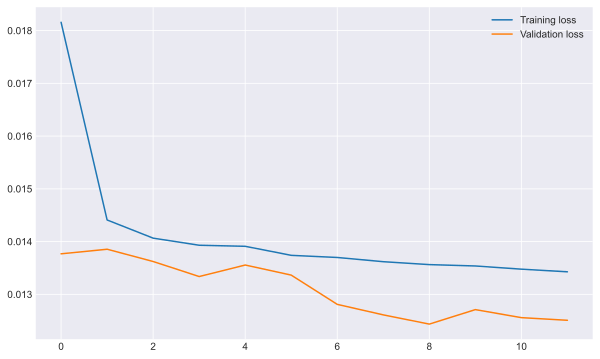

In [89]:
fig, axes = plt.subplots(figsize = (10,6))

axes.plot(history.history['loss'], label = 'Training loss')
axes.plot(history.history['val_loss'], label = 'Validation loss')

axes.grid()
axes.legend()

In [90]:
ar_lstm.summary()

Model: "auto_regressive_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_cell_1 (LSTMCell)          │ ?                      │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_1 (RNN)                     │ ?                      │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,504 (68.38 KB)

 Trainable params: 5,834 (22.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,670 (45.59 KB)

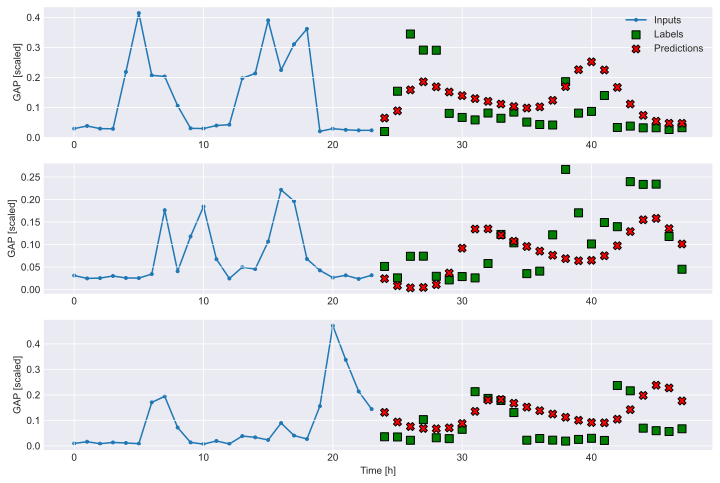

In [91]:
multi_window.plot(ar_lstm)

In [92]:
# Save performance 

val_performance['ARLSTM'] = ar_lstm.evaluate(multi_window.val, verbose = 0)
performance['ARLSTM'] = ar_lstm.evaluate(multi_window.test, verbose = 0)

Lets compare all models using MAE on the validation and test sets 

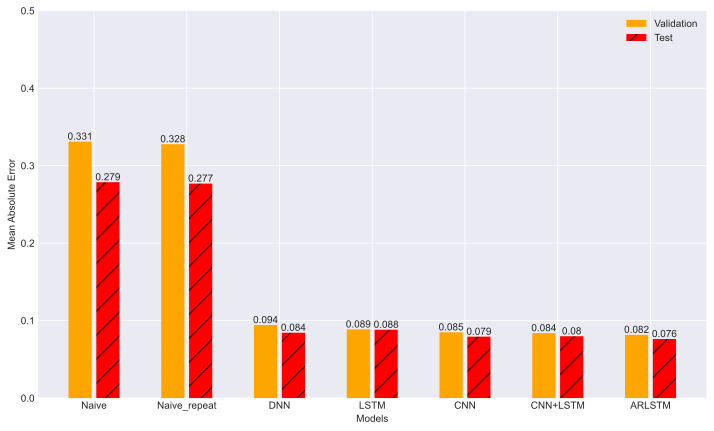

In [93]:
# Compare the baselines 

mae_val = [val[1] for val in val_performance.values()]
mae_test = [val[1] for val in performance.values()]

x = np.arange(len(performance))

fig, axes = plt.subplots(figsize = (12,7))

axes.bar(x - 0.15, mae_val, width = 0.25, color = 'orange', label = 'Validation')
axes.bar(x + 0.15, mae_test, width = 0.25, color = 'red', hatch = '/', label = 'Test')

for idx, val in enumerate(mae_val):

    axes.text(s = str(round(val,3)), x = idx - 0.15, y = val + 0.0025, ha = 'center')

for idx, val in enumerate(mae_test):

    axes.text(s = str(round(val,3)), x = idx + 0.15, y = val + 0.0025, ha = 'center')

axes.grid()
axes.set_ylabel('Mean Absolute Error')
axes.set_xlabel('Models')
axes.set_xticks(ticks = x, labels = performance.keys())
axes.set_ylim(0,0.5)
axes.legend()

The winner seems like Auto Regressive LSTM based on the performance in the test set.